# Analysis of Temporal Blocking

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from typing import Callable
from scipy.optimize import curve_fit
plt.style.use('default')

## Theoretical Analysis

Hyperparameter definitions
$$
\begin{aligned}
\lambda &= \frac{t_\text{compute} + t_\text{cache}}{t_\text{compute} + t_\text{memory}} \\
\mu &= \frac{\lambda}{1 - \lambda} \\
D &= \text{problem dimension} \\
\end{aligned}
$$
assume the block is square/cubic/etc.

Variables
$$
\begin{aligned}
I &= \text{number of iterations in one block} \\
B &= \text{block size (edge length)} \\
\end{aligned}
$$


Acceleration factor
$$
\begin{aligned}
\kappa_D(I, B) &=
\frac{
    (t_\text{compute} + t_\text{memory}) I
}{
    (t_\text{compute} + t_\text{memory}) +
    (t_\text{compute} + t_\text{cache})(I-1)
} 
\left(\frac{B - 2(I - 1)}{B}\right)^D \\
&=
\frac{
    \big(1 - \frac{2(I - 1)}{B}\big)^D
}{
    \frac{1}{I} + (1 - \frac{1}{I}) \lambda 
}
\end{aligned}
$$

Gradient of Acceleration
$$
\nabla \kappa_D
= \left[
    \begin{array}{c}
    \displaystyle\frac{\partial \kappa_D}{\partial I} \\
    \displaystyle\frac{\partial \kappa_D}{\partial B}
    \end{array}
\right]
=
\left[
    \begin{array}{c}
    \displaystyle\frac{
        \frac{1-\lambda}{(I-1)\lambda + 1} - 
        \frac{2D I}{(B - 2(I - 1))}
    }{
        (I-1)\lambda + 1
    }
    \\
    \displaystyle\frac{2I(I-1)D }{
        (B - 2(I - 1))
        ((I-1)\lambda + 1)^2
    }
    \end{array}
\right]
\cdot
\left(1 - \frac{2(I - 1)}{B}\right)^D
$$

Equation for contour lines
$$
B = \frac{2(I-1)}{
    1 - \sqrt[D]{ \left(
        \frac{1}{I} + \lambda(1 - \frac{1}{I})
    \right) \kappa}
}
\sim \frac{2}{
    1 - \sqrt[D]{ \lambda \kappa}
} I 
+ \frac{1
}{
    2 D\mu ~
        \text{sinh}^2\frac{\ln(\lambda \kappa)}{2D}
}
$$

Given $I$, the optimal $B$ is
$$
B_\text{opt} = 2D \mu I^2 + 2(D+1)I - 2
$$

Given $B$, the optimal $I$ is
$$
I_\text{opt} = \frac{
    \sqrt{
        2 B D \mu + D^2 +
        4 D \mu + 2D + 1
    }
    - (D+1)
}{
    2D\mu
}
$$

## Experiment Analysis

In [2]:
r = pickle.load(open("batch_experiment_results_s1o3.pkl", "rb"))
meta = r["metadata"]
r = pd.DataFrame(r["records"])
r["avg_speed"] = r['speeds'].map(lambda x: np.mean(x))
r["std_speed"] = r['speeds'].map(lambda x: np.std(x))
r.set_index(["block_count", "inner_loop"], inplace=True)

In [3]:
B = np.array(meta["tb_block_shape"])
D = 3
print(B)

[64 96 76]


In [4]:
def valid_interior_faction(n, I, B):
    return np.prod(np.where(n == 1, 1, (1 - 2 / n) * (1 - 2 * (I - 1) / B) + 2 / n * (1 - (I - 1) / B)), axis=-1)

In [5]:
n = np.array(r.index.get_level_values(0).unique().to_list())
print("Block counts tested:")
print(n)

Block counts tested:
[[ 1  1  1]
 [ 1  1  2]
 [ 1  1  3]
 ...
 [33  1  2]
 [33  2  1]
 [66  1  1]]


In [6]:
# sort by avg_speed
share_over_7000 = (r["avg_speed"].unstack().max(axis=1) > 7000).mean()
print(f"{share_over_7000:.1%} of domains achieve speedup > 7000 MLUPS")

80.4% of domains achieve speedup > 7000 MLUPS


Domain shape of (5,3,4): (288, 272, 280)
Domain shape of (1,2,1): (64, 172, 76)


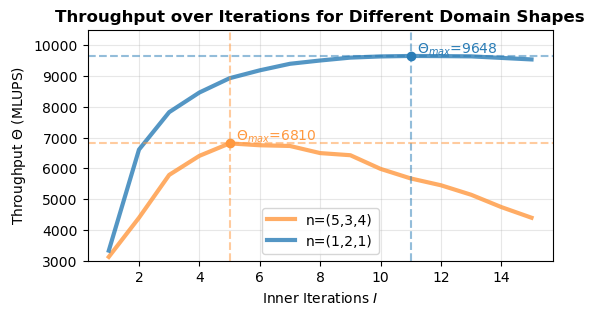

In [7]:
plt.figure(figsize=(6,3))
plt.plot(r.loc[(5, 3, 4), "avg_speed"], label="n=(5,3,4)", color="#ff983e", linewidth=3, alpha=0.8)
plt.plot(r.loc[(1, 2, 1), "avg_speed"], label="n=(1,2,1)", color="#297cb6", linewidth=3, alpha=0.8)
plt.scatter(5, r.loc[(5, 3, 4), "avg_speed"].loc[5], color="#ff983e")
plt.scatter(11, r.loc[(1, 2, 1), "avg_speed"].loc[11], color="#297cb6")

print("Domain shape of (5,3,4):", r.loc[(5, 3, 4)].loc[5, "domain_size"])
print("Domain shape of (1,2,1):", r.loc[(1, 2, 1)].loc[11, "domain_size"])
# Add dash lines to indicate the max points
plt.axvline(x=5, color='#ff983e', linestyle='--', alpha=0.5)
plt.axvline(x=11, color="#297cb6", linestyle="--", alpha=0.5)
plt.axhline(y=r.loc[(5, 3, 4), "avg_speed"].loc[5], color='#ff983e', linestyle='--', alpha=0.5)
plt.axhline(y=r.loc[(1, 2, 1), "avg_speed"].loc[11], color="#297cb6", linestyle="--", alpha=0.5)
# add text annotations
plt.text(5.2, r.loc[(5, 3, 4), "avg_speed"].loc[5]+100, f"$\\Theta_{{max}}$={r.loc[(5, 3, 4), 'avg_speed'].loc[5]:.0f}", color="#ff983e")
plt.text(11.2, r.loc[(1, 2, 1), "avg_speed"].loc[11]+100, f"$\\Theta_{{max}}$={r.loc[(1, 2, 1), 'avg_speed'].loc[11]:.0f}", color="#297cb6")
plt.xlabel("Inner Iterations $I$")
plt.ylabel("Throughput $\\Theta$ (MLUPS)")
plt.title("Throughput over Iterations for Different Domain Shapes", fontweight="bold", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(3000, 10500)
plt.savefig("throughput_vs_iterations.png", dpi=300, bbox_inches='tight')


Fitted lam: 0.284 ± 0.000


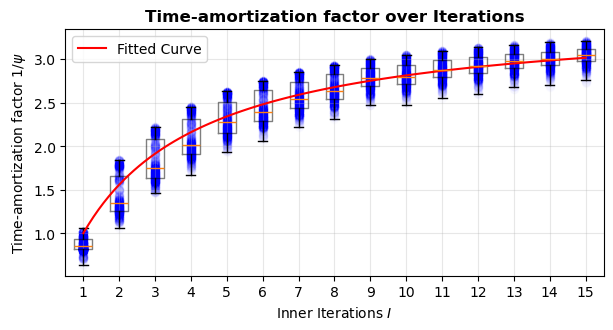

In [8]:
min_I = 0

x_data = []
y_data = []

for block_count in n[:]:
    kappa = r.loc[tuple(block_count), "avg_speed"]
    I = kappa.index.values
    phi = valid_interior_faction(block_count, I[:, None], B)
    if len(kappa) != len(phi):
        continue
    x_data.append(I[min_I:])
    y_data.append((kappa / phi).values[min_I:])

x_data = np.concatenate(x_data)
y_data = np.concatenate(y_data)


def psi_func(I, lam):
    return 1 / I + (1 - 1 / I) * lam

# fit the data
starting_guess = 0.3
C = 3814
params, covariance = curve_fit(lambda I, lam: 1 / psi_func(I, lam), x_data, y_data/C, p0=starting_guess)
lam, = params
print(f"Fitted lam: {lam:.3f} ± {np.sqrt(covariance[0,0]):.3f}")

mu = lam / (1 - lam)

plt.figure(figsize=(6, 3))

plt.scatter(x_data, y_data / C, color="blue", alpha=0.01)

unique_I = np.unique(x_data)
grouped_y = [y_data[x_data == val] / C for val in unique_I]
plt.boxplot(grouped_y, positions=unique_I, widths=0.5, showfliers=False, boxprops=dict(alpha=0.5))
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()

x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = psi_func(x_fit, lam)
plt.plot(x_fit, 1/y_fit, 'r-', label='Fitted Curve')
plt.xlabel("Inner Iterations $I$")
plt.ylabel("Time-amortization factor $1/\\psi$")
plt.title("Time-amortization factor over Iterations", fontweight="bold", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("time_amortization_factor.png", dpi=300, bbox_inches='tight')

In [9]:
def field_integrator(
    field_fn: Callable[[np.ndarray], np.ndarray],
    *,
    ds: float = 0.05,
    max_steps: int = 10000,
) -> Callable[[float, float], np.ndarray]:
    def integrate(x0: float, y0: float) -> np.ndarray:
        dt = ds
        trajectory = [np.array([x0, y0], dtype=float)]
        x, y = float(x0), float(y0)
        for _ in range(max_steps):
            field_value = field_fn(np.array([[x, y]], dtype=float))[0]
            speed = np.linalg.norm(field_value)
            direction_vec = field_value / speed
            x += direction_vec[0] * dt
            y += direction_vec[1] * dt
            trajectory.append(np.array([x, y], dtype=float))

        return np.array(trajectory)

    return integrate

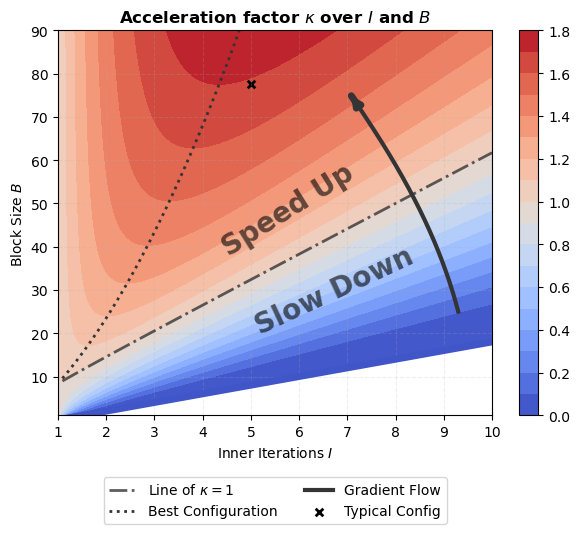

In [10]:
def speed_up(I, B):
    return ((1 - 2*(I-1)/B) ** D) / (1/I + lam * (1 - 1/I))


plt.figure(figsize=(7, 5))

B_min, B_max = 1, 90
I_min, I_max = 1, 10

plt.xlim(I_min, I_max)
plt.ylim(B_min, B_max)

I_grid, B_grid = np.meshgrid(np.linspace(I_min, I_max, 100), np.linspace(B_min, B_max, 100))
Z_grid = speed_up(I_grid, B_grid)
Z_grid[Z_grid < 0] = np.nan


level_step = 0.1
levels = np.arange(np.ceil(np.nanmax(Z_grid) / level_step) + 1) * level_step
cp = plt.contourf(I_grid, B_grid, Z_grid, levels=levels, cmap="coolwarm")
plt.colorbar(cp)
plt.grid(alpha=0.2, linestyle="--")
plt.xlabel("Inner Iterations $I$")
plt.ylabel("Block Size $B$")
plt.title("Acceleration factor $\\kappa$ over $I$ and $B$", fontweight="bold", fontsize=12)


l3 = lam ** (1 / 3)
t = np.linspace(I_min, I_max, 100)[1:]

plt.plot(t, 2 * (t - 1) / (1 - (1 / t + lam * (1 - 1 / t)) ** (1 / 3)), 
         color="#353535", linestyle="-.", linewidth=2, alpha=0.8,
         label="Line of $\\kappa=1$")
plt.plot(t, 2 * (t - 1), color="#4055c8", linewidth=5)
plt.plot(t, 2 * D * mu * t**2 + 2 * (D + 1) * t - 2, color="#343434", linewidth=2, linestyle=":", 
         label="Best Configuration")


ax = plt.gca()
data_ratio = ax.get_data_ratio()
bbox = ax.get_window_extent()
aspect_ratio = bbox.width / bbox.height
ratio = aspect_ratio * data_ratio

# get the gradient of Z
def speed_up_grad(I, B):
    l = I * lam + 1 - lam
    c = (1 - 2 * (I - 1) / B) ** D
    dkdI = ((1 - lam) / l**2 - 2 * D * I / (B - 2 * (I - 1)) / l) * c
    dkdB = (2 * I * (I - 1) * D / (B - 2 * (I - 1)) / l / B) * c
    g = np.array([dkdI, dkdB * ratio**2]).T
    return g


arr = field_integrator(
    field_fn=lambda p: speed_up_grad(p[:, 0], p[:, 1]),
    ds=0.05,
    max_steps=1000,
)(9.3, 25)
plt.text(4.3, 38, "Speed Up", color="black", fontsize=20, weight="bold", rotation=32, alpha=0.6)
plt.text(5.0, 20, "Slow Down", color="black", fontsize=20, weight="bold", rotation=25, alpha=0.6)
plt.plot(arr[:-50, 0], arr[:-50, 1], color="#343434", linewidth=3, 
         label="Gradient Flow")
plt.annotate(
    "",
    xytext=(arr[-2, 0], arr[-2, 1]),
    xy=(arr[-1, 0], arr[-1, 1]),
    arrowprops=dict(arrowstyle="->", color="#343434", linewidth=5),
)


# Add a point
point = (5, (32 * 2 * 16 * 6 * 2 * 38) ** (1 / 3))
plt.scatter(*point, color="black", s=30, label="Typical Config",
            marker="x", linewidths=2)

# make a legend under the plot
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.30), ncol=2)

# plt.xticks(np.arange(0, 21, 2))
plt.savefig("kappa_heatmap.png", dpi=300, bbox_inches="tight")
